**Starbucks customer behavior towards promotion segmentation**

**Objective**

The objective of this notebook is focused on 2 main tasks:
- Study how customers behave towards different types of offer and promotion in order to identify which offer type is the most effective in turning customers into buying as well as which offer type is problematic. As a result, marketing team can develop a more effective promotion strategy for future campaigns. (By further develop the most effective offer type for example)
- Segmentize customers based on their demographics, purchasing behaviour, and interaction towards different offer type for more effective future targeted marketing.

**Content**

The notebook contains the following parts:

- Understand the datasets.
- Preprocess the 3 original datasets to create a master customers dataframe.
    - Impute missing data
    - Convert dates to Datetime
    - One hot encoding for categorical features
    - Examine and handle duplicate records in offers dataframe
    - Drop implausible records
    - Compute statistics related to offers features: conversion rates
    - Compute statistics related to transactions features: frequency, recency, monetary
    - Create master customers dataframe
- Data exploratory analysis for master customers dataframe
- Data preprocessing for master customers dataframe with standardization and PCA
- Models
    - Kmeans
        - Find number of clusters with Elbow, silhouette, calinski harabasz, and davies bouldin scores
        - Fit the model
        - Evaluate clusters on PCA visualization
    - DBSCAN
        - Search for parameters
        - Fit the model
        - Evaluate model
- Cluster evaluation 

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import SilhouetteVisualizer

from collections import Counter

plt.style.use('fivethirtyeight')
plt.style.use('seaborn')

In [2]:
portfolio = pd.read_json('.\data\portfolio.json', orient='records', lines=True)
profile = pd.read_json('.\data\profile.json', orient='records', lines=True)
transcript = pd.read_json('./data/transcript.json', orient='records', lines=True)

# Understand the dataset

**Dataset**

**portfolio.json** - offer ids and their meta data

- id (string): id of an offer

- offer_type (string): offer type (BOGO (Buy one get one), discount, informational)

- difficulty (int): minimum required spent to complete an offer

- reward (int): reward for completing an offer

- duration (int): length of days that the offer is valid

- channels (list of strings): type of channel that an offer is sent to a customer

**profile.json** - customer demographic info

- age (int): age

- became_member_on (int): year that customer create an account on the app

- gender (str):  gender

- id (str): customer id

- income (float): income

**transcript.json** - records of offers: received, viewed, and completed as well as records of transactions made by customers

- event (str): type of record

- person (str): customer id
- time (int): length of hours since start of test. The data begins at time t=0

- value (dict of strings): either an offer id or transaction amount depending on the record



In [3]:
portfolio

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
5  2298d6c36e964ae4a3e7e9706d1fb8c2       discount       3  
6  fafdcd668e3743c1bb461111dcafc2a4       discount       2  
7  5a8bc65990b245e5a138643cd4eb9837  informational       0  
8  f19421c1d4aa40978ebb69ca19b0e20d           bogo       5  
9  2906b810c7d4411798c6938adc9daaa5       discount       2

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
profile.head()

age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN

In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [7]:
transcript.head()

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}

In [8]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# Preprocess the data to create a master customers dataframe

**Impute missing data**

From the above, portfolio and transcript do not have missing values. Profile has missing values in **gender** and **income** columns

In [9]:
profile['gender'] = profile['gender'].fillna('NA')
profile.gender.value_counts()

M     8484
F     6129
NA    2175
O      212
Name: gender, dtype: int64

In [10]:
income_not_null =profile[profile['income'].notnull()]

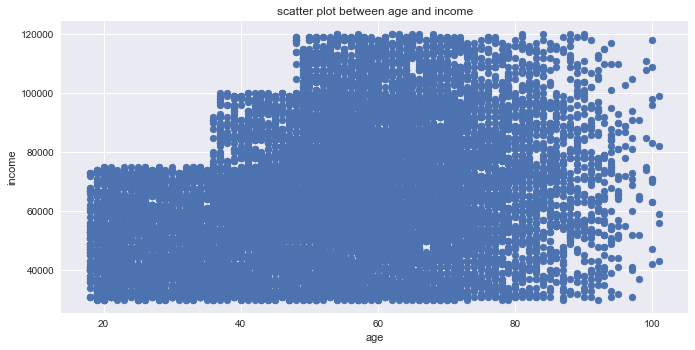

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(income_not_null['age'],income_not_null['income'])
plt.title('scatter plot between age and income')
plt.xlabel('age')
plt.ylabel('income')
plt.show()

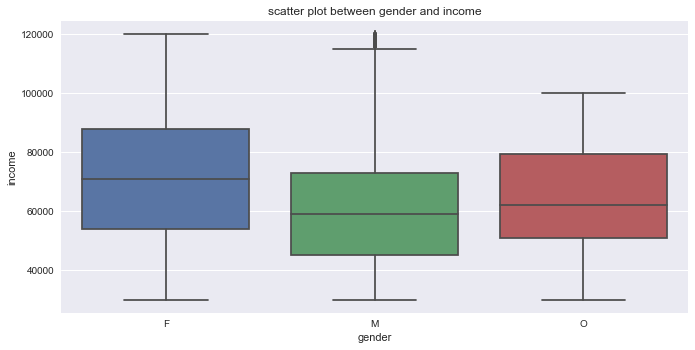

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(x='gender',y='income',data=income_not_null)
plt.title('scatter plot between gender and income')
plt.xlabel('gender')
plt.ylabel('income')
plt.show()

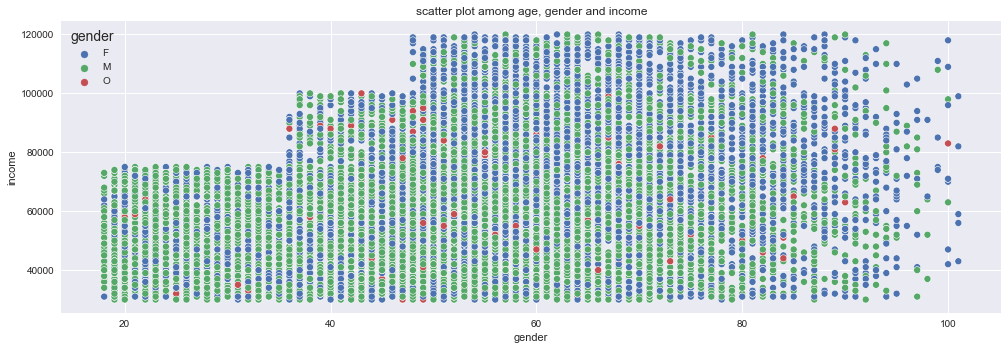

In [13]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='age',y='income',hue='gender',data=income_not_null)
plt.title('scatter plot among age, gender and income')
plt.xlabel('gender')
plt.ylabel('income')
plt.show()

It is observed that income differs among 3 age groups:<= 35, >35 and <=47, >47. Income also differs among female and male especially in the oldest group. Thus I will impute the missing data using the following rules:

- age group <= 35: mean data of the whole group
- age group >35 and <=47: mean data of the whole group
- age group >47: mean data of female for female missing income, mean data of male for male missing income, mean data of the whole group for unknow/other gender.

In [14]:
group1 = profile['age'] <= 35
group2 = (profile['age'] > 35) & (profile['age'] <=47)
group3_female = (profile['age'] > 47) & (profile['gender'] =='F')
group3_male = (profile['age'] > 47) & (profile['gender'] =='M')

profile.loc[group1,'income'] = profile.loc[group1,'income'].fillna(profile.loc[group1,'income'].mean())
profile.loc[group2,'income'] = profile.loc[group2,'income'].fillna(profile.loc[group2,'income'].mean())
profile.loc[group3_female,'income'] = profile.loc[group3_female,'income'].fillna(profile.loc[group3_female,'income'].mean())
profile.loc[group3_male,'income'] = profile.loc[group3_male,'income'].fillna(profile.loc[group3_male,'income'].mean())

In [15]:
profile['income'] = profile['income'].fillna(profile['income'].mean())

In [16]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              17000 non-null object
id                  17000 non-null object
income              17000 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


**Convert dates to Datetime**

In [17]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

**Separate transcript into 2 dataframes: offers and transactions**

- **offers**: dataframe that includes customers' activity on an received offer. A customer can receive many offers. Then view an offer or not, and complete an offer or not. 

- **transactions**: dataframe that includes transactions made by customers during the campaign period.

In [18]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Offers dataframe includes records of:
- offer received
- offer viewed
- offer completed

Transactions dataframe includes records of:
- transaction

In [19]:
transactions = pd.DataFrame(transcript[transcript['event'] =='transaction'])
offers = pd.DataFrame(transcript[transcript['event'] !='transaction'])

In [20]:
transactions['value_amount'] = transactions['value'].apply(lambda x: list(x.values())[0])

In [21]:
offers['offer_id']=offers['value'].apply(lambda x: list(x.values())[0])    

In [22]:
transactions.head()

event                            person  time  \
12654  transaction  02c083884c7d45b39cc68e1314fec56c     0   
12657  transaction  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f     0   
12659  transaction  54890f68699049c2a04d415abc25e717     0   
12670  transaction  b2f1cd155b864803ad8334cdf13c4bd2     0   
12671  transaction  fe97aa22dd3e48c8b143116a8403dd52     0   

                                value  value_amount  
12654  {'amount': 0.8300000000000001}          0.83  
12657               {'amount': 34.56}         34.56  
12659               {'amount': 13.23}         13.23  
12670               {'amount': 19.51}         19.51  
12671               {'amount': 18.97}         18.97

In [23]:
offers.head()

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}   

                           offer_id  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7  
2  2906b810c7d4411798c6938adc9daaa5  
3  fafdcd668e3743c1bb461111dcafc2a4  
4  4d5c57ea9a6940dd891ad53e9dbe8da0

**Merge transactions and offers with profile and portfolio**

In [24]:
offers = offers.merge(profile, left_on='person', right_on='id')
offers = offers.merge(portfolio, left_on='offer_id', right_on='id')
transactions = transactions.merge(profile, left_on='person', right_on='id')

In [25]:
offers.drop(['id_x', 'id_y','value'], axis=1, inplace=True)
transactions.drop(['value','id'], axis=1, inplace=True)

In [26]:
transactions.head()

event                            person  time  value_amount  age  \
0  transaction  02c083884c7d45b39cc68e1314fec56c     0          0.83   20   
1  transaction  02c083884c7d45b39cc68e1314fec56c     6          1.44   20   
2  transaction  02c083884c7d45b39cc68e1314fec56c    12          4.56   20   
3  transaction  02c083884c7d45b39cc68e1314fec56c    84          1.53   20   
4  transaction  02c083884c7d45b39cc68e1314fec56c    90          0.50   20   

  became_member_on gender   income  
0       2016-07-11      F  30000.0  
1       2016-07-11      F  30000.0  
2       2016-07-11      F  30000.0  
3       2016-07-11      F  30000.0  
4       2016-07-11      F  30000.0

In [27]:
offers.head()

event                            person  time  \
0   offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1     offer viewed  78afa995795e4d85b5d9ceeca43f5fef     6   
2  offer completed  78afa995795e4d85b5d9ceeca43f5fef   132   
3   offer received  e2127556f4f64592b11af22de27a7932   408   
4     offer viewed  e2127556f4f64592b11af22de27a7932   420   

                           offer_id  age became_member_on gender    income  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9   75       2017-05-09      F  100000.0   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9   75       2017-05-09      F  100000.0   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9   75       2017-05-09      F  100000.0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9   68       2018-04-26      M   70000.0   
4  9b98b8c7a33c4b65b9aebfe6a799e6d9   68       2018-04-26      M   70000.0   

               channels  difficulty  duration offer_type  reward  
0  [web, email, mobile]           5         7       bogo       5  
1  [web, email, mobile]           5         7       bogo       5  
2  [web, email, mobile]           5         7       bogo       5  
3  [web, email, mobile]           5         7       bogo       5  
4  [web, email, mobile]           5         7       bogo       5

**Separate time column for different kind of offer events in offers dataframe**

In [28]:
offers.event.value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

In [29]:
received_time = []
for i in range(offers.shape[0]):
    if offers['event'][i] == 'offer received':
        time = offers['time'][i] 
    else:
        time = 0
    received_time.append(time)

In [30]:
viewed_time = []
for i in range(offers.shape[0]):
    if offers['event'][i] == 'offer viewed':
        time = offers['time'][i] 
    else:
        time = 0
    viewed_time.append(time)

In [31]:
completed_time = []
for i in range(offers.shape[0]):
    if offers['event'][i] == 'offer completed':
        time = offers['time'][i] 
    else:
        time = 0
    completed_time.append(time)

In [32]:
offers['time'] = offers['time'] 
offers['received_time'] = received_time
offers['viewed_time'] = viewed_time
offers['completed_time'] = completed_time

**One hot encoding for both offers and transactions dataframe**

In [33]:
from sklearn.preprocessing import MultiLabelBinarizer

In [34]:
multi_lb = MultiLabelBinarizer()

#Offers dataframe
dummies_channels = pd.DataFrame(multi_lb.fit_transform(offers['channels']), columns=multi_lb.classes_, index=offers.index)

dummies_offer_type= offers['offer_type'].str.get_dummies()

dummies_gender = offers['gender'].str.get_dummies().add_prefix('gender_')

offers['joined_since'] = offers['became_member_on'].apply(lambda x: str(x.year))
dummies_joined_since = offers['joined_since'].str.get_dummies().add_prefix('joined_since_')

dummies_event = offers['event'].str.get_dummies()

offers = pd.concat([offers, dummies_channels, dummies_offer_type,dummies_gender, dummies_joined_since,dummies_event], axis=1)

offers.drop(['became_member_on'], axis=1, inplace=True)
offers.drop(['joined_since'], axis=1, inplace=True)

offers.head()

event                            person  time  \
0   offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1     offer viewed  78afa995795e4d85b5d9ceeca43f5fef     6   
2  offer completed  78afa995795e4d85b5d9ceeca43f5fef   132   
3   offer received  e2127556f4f64592b11af22de27a7932   408   
4     offer viewed  e2127556f4f64592b11af22de27a7932   420   

                           offer_id  age gender    income  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9   75      F  100000.0   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9   75      F  100000.0   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9   75      F  100000.0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9   68      M   70000.0   
4  9b98b8c7a33c4b65b9aebfe6a799e6d9   68      M   70000.0   

               channels  difficulty  duration  ... gender_O  \
0  [web, email, mobile]           5         7  ...        0   
1  [web, email, mobile]           5         7  ...        0   
2  [web, email, mobile]           5         7  ...        0   
3  [web, email, mobile]           5         7  ...        0   
4  [web, email, mobile]           5         7  ...        0   

   joined_since_2013  joined_since_2014  joined_since_2015  joined_since_2016  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   joined_since_2017  joined_since_2018  offer completed  offer received  \
0                  1                  0                0               1   
1                  1                  0                0               0   
2                  1                  0                1               0   
3                  0                  1                0               1   
4                  0                  1                0               0   

   offer viewed  
0             0  
1             1  
2             0  
3             0  
4             1  

[5 rows x 35 columns]

In [35]:
# Transactions dataframe

dummies_gender = transactions['gender'].str.get_dummies().add_prefix('gender_')

transactions['joined_since'] = transactions['became_member_on'].apply(lambda x: str(x.year))
dummies_joined_since = transactions['joined_since'].str.get_dummies().add_prefix('joined_since_')

transactions = pd.concat([transactions, dummies_gender, dummies_joined_since], axis=1)

transactions.drop(['became_member_on'], axis=1, inplace=True)
transactions.drop(['joined_since'], axis=1, inplace=True)

transactions.head()

event                            person  time  value_amount  age  \
0  transaction  02c083884c7d45b39cc68e1314fec56c     0          0.83   20   
1  transaction  02c083884c7d45b39cc68e1314fec56c     6          1.44   20   
2  transaction  02c083884c7d45b39cc68e1314fec56c    12          4.56   20   
3  transaction  02c083884c7d45b39cc68e1314fec56c    84          1.53   20   
4  transaction  02c083884c7d45b39cc68e1314fec56c    90          0.50   20   

  gender   income  gender_F  gender_M  gender_NA  gender_O  joined_since_2013  \
0      F  30000.0         1         0          0         0                  0   
1      F  30000.0         1         0          0         0                  0   
2      F  30000.0         1         0          0         0                  0   
3      F  30000.0         1         0          0         0                  0   
4      F  30000.0         1         0          0         0                  0   

   joined_since_2014  joined_since_2015  joined_since_2016  joined_since_2017  \
0                  0                  0                  1                  0   
1                  0                  0                  1                  0   
2                  0                  0                  1                  0   
3                  0                  0                  1                  0   
4                  0                  0                  1                  0   

   joined_since_2018  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0

**Examine and handle duplicate records in offers dataframe**

In [36]:
offers.reset_index(inplace=True)

In [37]:
offers[offers.duplicated(subset=['offer_id', 'person'], keep=False)].shape

(159041, 36)

In [38]:
offers.shape

(167581, 36)

**Create new dataframe grouped_offers from offers dataframe**

It is observed that there duplicated records with the same offer_id and person id. This means that a customer can receive and view an offer  multiple times. Here we will create new dataframe **grouped_offers** that keeps the first record of each unique identity "customer id and offer id" plus the tracks of all the records related to that identity. To be more specific, for 1 record, it will have:
- a unique identity which is a combination of customer id and offer id
- demographic info of that customer
- info related to that offer when the offer is received the first time
- info of the number of time that the offer is received, viewed and completed by that customer.

In [39]:
first_event = offers.groupby(['person', 'offer_id', 'event']).min()
total_events = offers.groupby(['person', 'offer_id', 'event'])[['offer received', 'offer viewed', 'offer completed']].sum()
first_event.update(total_events)
grouped_offers = first_event.groupby(['person', 'offer_id']).max().reset_index()
grouped_offers.fillna(0, inplace=True)
grouped_offers.head()

person                          offer_id   index  \
0  0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5  106223   
1  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   91162   
2  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   27938   
3  0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d   64370   
4  0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4  125687   

   time  age gender   income                      channels  difficulty  \
0   576   33      M  72000.0          [web, email, mobile]          10   
1   372   33      M  72000.0          [web, email, mobile]           0   
2   192   33      M  72000.0       [email, mobile, social]           0   
3   456   33      M  72000.0  [web, email, mobile, social]           5   
4   540   33      M  72000.0  [web, email, mobile, social]          10   

   duration  ... gender_O  joined_since_2013  joined_since_2014  \
0         7  ...        0                  0                  0   
1         4  ...        0                  0                  0   
2         3  ...        0                  0                  0   
3         5  ...        0                  0                  0   
4        10  ...        0                  0                  0   

   joined_since_2015  joined_since_2016  joined_since_2017  joined_since_2018  \
0                  0                  0                  1                  0   
1                  0                  0                  1                  0   
2                  0                  0                  1                  0   
3                  0                  0                  1                  0   
4                  0                  0                  1                  0   

   offer completed  offer received  offer viewed  
0                1               1             0  
1                0               1             1  
2                0               1             1  
3                1               1             1  
4                1               1             1  

[5 rows x 35 columns]

**Drop implausible records in grouped_offers dataframe**
- Completed before viewed
- Completed without viewed
- Viewed before received

In [40]:
grouped_offers=grouped_offers[~((grouped_offers['viewed_time'] < grouped_offers['received_time'])&(grouped_offers['viewed_time']!= 0))]
grouped_offers=grouped_offers[~((grouped_offers['viewed_time'] ==0)&(grouped_offers['completed_time'] > 0))]
grouped_offers=grouped_offers[~((grouped_offers['completed_time'] < grouped_offers['viewed_time'])&(grouped_offers['completed_time']!= 0))]

**Statistics related to offers**

These below offers related statistics are derived from grouped_offers dataframe

- Conversion rates 
- Other statistics related to offers of each customer

**Create conversion rates**

In [41]:
grouped_offers['offer_type'].value_counts()

bogo             21139
discount         20390
informational    12651
Name: offer_type, dtype: int64

Conversion rates are created for 3 types of offers: Bogo, discount, and information as well as for all types combined.

***Conversion rates - Bogo***

In [42]:
# Offer type Bogo

bogo = grouped_offers[grouped_offers['offer_type'] == 'bogo'].groupby(['person'],sort=False).agg({
    'offer received': 'sum',
    'offer viewed': 'sum',
    'offer completed': 'sum',
}
)
bogo = bogo.rename(columns={"offer received":"BOGO_received_count",
                            "offer viewed":"BOGO_viewed_count",
                            "offer completed":"BOGO_completed_count"})

# calculate conversion rates
bogo['BOGO_viewed_received_cr'] = bogo['BOGO_viewed_count']/ bogo['BOGO_received_count']
bogo['BOGO_completed_viewed_cr'] = bogo['BOGO_completed_count']/ bogo['BOGO_viewed_count']
bogo['BOGO_completed_received_cr'] = bogo['BOGO_completed_count']/ bogo['BOGO_received_count']
#bogo = bogo[['BOGO_viewed_received_cr','BOGO_completed_viewed_cr','BOGO_completed_received_cr']]

In [43]:
bogo =bogo.replace(np.inf, 0)
bogo.fillna(0, inplace=True)

***Conversion rates - Discount***

In [44]:
# Offer type discount
discount = grouped_offers[grouped_offers['offer_type'] == 'discount'].groupby(['person']).agg({
    'offer received': 'sum',
    'offer viewed': 'sum',
    'offer completed': 'sum',    
})
discount = discount.rename(columns={"offer received":"DISC_received_count",
                            "offer viewed":"DISC_viewed_count",
                            "offer completed":"DISC_completed_count"})
# calculate conversion rates
discount['DISC_viewed_received_cr'] = discount['DISC_viewed_count']/ discount['DISC_received_count']
discount['DISC_completed_viewed_cr'] = discount['DISC_completed_count']/ discount['DISC_viewed_count']
discount['DISC_completed_received_cr'] = discount['DISC_completed_count']/ discount['DISC_received_count']
#discount[['DISC_viewed_received_cr','DISC_completed_viewed_cr','DISC_completed_received_cr']]

In [45]:
discount.fillna(0, inplace=True)
discount =discount.replace(np.inf, 0)

***Conversion rates - Informational***

In [46]:
# Offer type informational
informational = grouped_offers[grouped_offers['offer_type'] == 'informational'].groupby(['person']).agg({
    'offer received': 'sum',
    'offer viewed': 'sum',
    'offer completed': 'sum',    
})
informational = informational.rename(columns={"offer received":"INFO_received_count",
                            "offer viewed":"INFO_viewed_count",
                            "offer completed":"INFO_completed_count"})
# calculate conversion rates
informational['INFO_viewed_received_cr'] = informational['INFO_viewed_count']/ informational['INFO_received_count']
informational['INFO_completed_viewed_cr'] = informational['INFO_completed_count']/ informational['INFO_viewed_count']
informational['INFO_completed_received_cr'] = informational['INFO_completed_count']/ informational['INFO_received_count']
#informational = informational[['INFO_viewed_received_cr','INFO_completed_viewed_cr','INFO_completed_received_cr']]

In [47]:
informational.fillna(0, inplace=True)
informational =informational.replace(np.inf, 0)

***Conversion rates - All offer types***

In [48]:
# Offer all types

all_types = grouped_offers.groupby(['person']).agg({
    'offer received': 'sum',
    'offer viewed': 'sum',
    'offer completed': 'sum',    
})
all_types = all_types.rename(columns={"offer received":"ALL_received_count",
                            "offer viewed":"ALL_viewed_count",
                            "offer completed":"ALL_completed_count"})

# calculate conversion rates
all_types['ALL_viewed_received_cr'] = all_types['ALL_viewed_count']/ all_types['ALL_received_count']
all_types['ALL_completed_viewed_cr'] = all_types['ALL_completed_count']/ all_types['ALL_viewed_count']
all_types['ALL_completed_received_cr'] = all_types['ALL_completed_count']/ all_types['ALL_received_count']
#all_types = all_types[['ALL_viewed_received_cr','ALL_completed_viewed_cr','ALL_completed_received_cr']]

In [49]:
all_types.fillna(0, inplace=True)
all_types =all_types.replace(np.inf, 0)

**Create dataframe customer_offers that holds other statistics related to offers for each customer**

In [50]:
customer_offers = grouped_offers.groupby('person').agg({
    'reward': 'mean',
    'difficulty': 'mean',
    'email':'sum',
    'mobile': 'sum',
    'social': 'sum',
    'web': 'sum',
    'bogo':'sum',
    'discount': 'sum',
    'informational': 'sum',
    'offer received': 'mean',
    'offer viewed': 'mean',
    'offer completed': 'mean',
    'duration': 'mean',


})

#customer_offers.columns = ["_".join(x) for x in customer_offers.columns.ravel()]

customer_offers = customer_offers.rename(columns={
    "reward":"reward_average",
    'difficulty': 'difficulty_average',
    'email':'email_count',
    'mobile': 'mobile_count',
    'social': 'social_count',
    'web': 'web_count',
    'bogo':'BOGO_count',
    'discount': 'DISC_count',
    'informational': 'INFO_count',
    'offer received': 'ALL_received_average',
    'offer viewed': 'ALL_viewed_average',
    'offer completed': 'ALL_completed_average'
                                                 })

In [51]:
customer_offers.head()

reward_average  difficulty_average  \
person                                                                 
0009655768c64bdeb2e877511632db8f            0.00                0.00   
00116118485d4dfda04fdbaba9a87b5c            5.00                5.00   
0011e0d4e6b944f998e987f904e8c1e5            2.60                6.40   
0020c2b971eb4e9188eac86d93036a77            5.50                7.50   
0020ccbbb6d84e358d3414a3ff76cffd            3.25                4.25   

                                  email_count  mobile_count  social_count  \
person                                                                      
0009655768c64bdeb2e877511632db8f            2             2             1   
00116118485d4dfda04fdbaba9a87b5c            1             1             1   
0011e0d4e6b944f998e987f904e8c1e5            5             4             2   
0020c2b971eb4e9188eac86d93036a77            4             4             4   
0020ccbbb6d84e358d3414a3ff76cffd            4             4             3   

                                  web_count  BOGO_count  DISC_count  \
person                                                                
0009655768c64bdeb2e877511632db8f          1           0           0   
00116118485d4dfda04fdbaba9a87b5c          1           1           0   
0011e0d4e6b944f998e987f904e8c1e5          4           1           2   
0020c2b971eb4e9188eac86d93036a77          2           2           1   
0020ccbbb6d84e358d3414a3ff76cffd          3           2           1   

                                  INFO_count  ALL_received_average  \
person                                                               
0009655768c64bdeb2e877511632db8f           2                  1.00   
00116118485d4dfda04fdbaba9a87b5c           0                  2.00   
0011e0d4e6b944f998e987f904e8c1e5           2                  1.00   
0020c2b971eb4e9188eac86d93036a77           1                  1.25   
0020ccbbb6d84e358d3414a3ff76cffd           1                  1.00   

                                  ALL_viewed_average  ALL_completed_average  \
person                                                                        
0009655768c64bdeb2e877511632db8f                1.00                   0.00   
00116118485d4dfda04fdbaba9a87b5c                2.00                   0.00   
0011e0d4e6b944f998e987f904e8c1e5                1.00                   0.60   
0020c2b971eb4e9188eac86d93036a77                0.75                   0.75   
0020ccbbb6d84e358d3414a3ff76cffd                1.00                   0.75   

                                  duration  
person                                      
0009655768c64bdeb2e877511632db8f      3.50  
00116118485d4dfda04fdbaba9a87b5c      5.00  
0011e0d4e6b944f998e987f904e8c1e5      6.20  
0020c2b971eb4e9188eac86d93036a77      6.25  
0020ccbbb6d84e358d3414a3ff76cffd      5.50

**Statistics related to transactions**

Here we will group transactions by customer:

- How many transactions each customer has
- The first and last transactional dates and how many days in between
- How much in total each customer spent, what is the minimum and maximum amount

In [52]:
# time to Datetime
transactions['datetime'] = transactions['time'].apply(lambda x: pd.Timestamp('2000-01-01T12') + pd.Timedelta(hours=x))
transactions.head()

event                            person  time  value_amount  age  \
0  transaction  02c083884c7d45b39cc68e1314fec56c     0          0.83   20   
1  transaction  02c083884c7d45b39cc68e1314fec56c     6          1.44   20   
2  transaction  02c083884c7d45b39cc68e1314fec56c    12          4.56   20   
3  transaction  02c083884c7d45b39cc68e1314fec56c    84          1.53   20   
4  transaction  02c083884c7d45b39cc68e1314fec56c    90          0.50   20   

  gender   income  gender_F  gender_M  gender_NA  gender_O  joined_since_2013  \
0      F  30000.0         1         0          0         0                  0   
1      F  30000.0         1         0          0         0                  0   
2      F  30000.0         1         0          0         0                  0   
3      F  30000.0         1         0          0         0                  0   
4      F  30000.0         1         0          0         0                  0   

   joined_since_2014  joined_since_2015  joined_since_2016  joined_since_2017  \
0                  0                  0                  1                  0   
1                  0                  0                  1                  0   
2                  0                  0                  1                  0   
3                  0                  0                  1                  0   
4                  0                  0                  1                  0   

   joined_since_2018            datetime  
0                  0 2000-01-01 12:00:00  
1                  0 2000-01-01 18:00:00  
2                  0 2000-01-02 00:00:00  
3                  0 2000-01-05 00:00:00  
4                  0 2000-01-05 06:00:00

In [53]:
group_by_date = transactions.groupby(['person'],sort=False)['datetime'].agg(["min", "max", "count"])

group_by_date["recency"] = (group_by_date["max"] - group_by_date["min"]) / np.timedelta64(1, 'D') / 1

group_by_date =group_by_date.rename(columns={"min": "first_transaction_date", "max": "last_transaction_date","count": "num_transactions"})
group_by_date.head()

first_transaction_date last_transaction_date  \
person                                                                          
02c083884c7d45b39cc68e1314fec56c    2000-01-01 12:00:00   2000-01-19 00:00:00   
9fa9ae8f57894cc9a3b8a9bbe0fc1b2f    2000-01-01 12:00:00   2000-01-24 00:00:00   
54890f68699049c2a04d415abc25e717    2000-01-01 12:00:00   2000-01-30 00:00:00   
b2f1cd155b864803ad8334cdf13c4bd2    2000-01-01 12:00:00   2000-01-25 06:00:00   
fe97aa22dd3e48c8b143116a8403dd52    2000-01-01 12:00:00   2000-01-31 00:00:00   

                                  num_transactions  recency  
person                                                       
02c083884c7d45b39cc68e1314fec56c                10    17.50  
9fa9ae8f57894cc9a3b8a9bbe0fc1b2f                12    22.50  
54890f68699049c2a04d415abc25e717                 7    28.50  
b2f1cd155b864803ad8334cdf13c4bd2                 8    23.75  
fe97aa22dd3e48c8b143116a8403dd52                11    29.50

In [54]:
group_by_value_amount = transactions.groupby(['person'],sort=False)['value_amount'].agg(['min','max','sum'])
group_by_value_amount = group_by_value_amount.rename(columns={"min":"min_transaction_value","max":"max_transaction_value","sum":"total_transaction_value"})
group_by_value_amount.head()

min_transaction_value  \
person                                                    
02c083884c7d45b39cc68e1314fec56c                   0.50   
9fa9ae8f57894cc9a3b8a9bbe0fc1b2f                  18.42   
54890f68699049c2a04d415abc25e717                   7.78   
b2f1cd155b864803ad8334cdf13c4bd2                  17.53   
fe97aa22dd3e48c8b143116a8403dd52                  10.30   

                                  max_transaction_value  \
person                                                    
02c083884c7d45b39cc68e1314fec56c                   9.80   
9fa9ae8f57894cc9a3b8a9bbe0fc1b2f                  34.56   
54890f68699049c2a04d415abc25e717                  22.39   
b2f1cd155b864803ad8334cdf13c4bd2                  29.95   
fe97aa22dd3e48c8b143116a8403dd52                 380.24   

                                  total_transaction_value  
person                                                     
02c083884c7d45b39cc68e1314fec56c                    29.89  
9fa9ae8f57894cc9a3b8a9bbe0fc1b2f                   320.48  
54890f68699049c2a04d415abc25e717                   118.85  
b2f1cd155b864803ad8334cdf13c4bd2                   195.35  
fe97aa22dd3e48c8b143116a8403dd52                   562.77

We can use summary_data_from_transaction_data from lifetimes.utils to get:
- frequency (how many transactions made)
- recency (how many days between first and last transaction)
- monetary_value (the average spend by a customer per repeat purchase day)

In [55]:
from lifetimes.utils import summary_data_from_transaction_data

In [56]:
transactions_summary = summary_data_from_transaction_data(transactions, 'person', 'datetime', monetary_value_col='value_amount')
transactions_summary.drop('T', axis=1, inplace=True)
transactions_summary.head()

frequency  recency  monetary_value
person                                                              
0009655768c64bdeb2e877511632db8f        6.0     19.0       17.573333
00116118485d4dfda04fdbaba9a87b5c        2.0      8.0        1.695000
0011e0d4e6b944f998e987f904e8c1e5        3.0     21.0       21.990000
0020c2b971eb4e9188eac86d93036a77        6.0     28.0       29.871667
0020ccbbb6d84e358d3414a3ff76cffd        9.0     26.0       15.308889

In [57]:
transactions_unique = transactions[['person',
       'gender_F', 'gender_M', 'gender_NA', 'gender_O', 'joined_since_2013',
       'joined_since_2014', 'joined_since_2015', 'joined_since_2016',
       'joined_since_2017', 'joined_since_2018']].drop_duplicates()

In [58]:
transactions_unique.set_index('person',inplace=True)

**Create customers dataframe**

Finally we can create customers dataframe which holds all the statistics related to offers and transactions we derived above for all customers.

In [59]:
profile.rename({'id': 'person'}, axis=1, inplace=True)
profile.set_index('person', inplace=True)

In [60]:
customers = profile.join(transactions_summary)

In [61]:
customers.drop(columns=['gender','became_member_on'],inplace=True)

In [62]:
customers = customers.join(bogo)
customers = customers.join(discount)
customers = customers.join(informational)
customers = customers.join(all_types)
customers = customers.join(customer_offers)
customers = customers.join(transactions_unique)
customers.fillna(0, inplace=True)
customers.head()

age         income  frequency  recency  \
person                                                                     
68be06ca386d4c31939f3a4f0e3dd783  118   65404.991568        8.0     14.0   
0610b486422d4921ae7d2bf64640c50b   55  112000.000000        2.0     21.0   
38fe809add3b4fcf9315a9694bb96ff5  118   65404.991568        5.0     23.0   
78afa995795e4d85b5d9ceeca43f5fef   75  100000.000000        5.0     16.0   
a03223e636434f42ac4c3df47e8bac43  118   65404.991568        2.0     16.0   

                                  monetary_value  BOGO_received_count  \
person                                                                  
68be06ca386d4c31939f3a4f0e3dd783         2.50625                  0.0   
0610b486422d4921ae7d2bf64640c50b        27.75000                  0.0   
38fe809add3b4fcf9315a9694bb96ff5         2.59200                  1.0   
78afa995795e4d85b5d9ceeca43f5fef        24.32000                  2.0   
a03223e636434f42ac4c3df47e8bac43         1.78000                  0.0   

                                  BOGO_viewed_count  BOGO_completed_count  \
person                                                                      
68be06ca386d4c31939f3a4f0e3dd783                0.0                   0.0   
0610b486422d4921ae7d2bf64640c50b                0.0                   0.0   
38fe809add3b4fcf9315a9694bb96ff5                1.0                   0.0   
78afa995795e4d85b5d9ceeca43f5fef                2.0                   2.0   
a03223e636434f42ac4c3df47e8bac43                0.0                   0.0   

                                  BOGO_viewed_received_cr  \
person                                                      
68be06ca386d4c31939f3a4f0e3dd783                      0.0   
0610b486422d4921ae7d2bf64640c50b                      0.0   
38fe809add3b4fcf9315a9694bb96ff5                      1.0   
78afa995795e4d85b5d9ceeca43f5fef                      1.0   
a03223e636434f42ac4c3df47e8bac43                      0.0   

                                  BOGO_completed_viewed_cr  ...  gender_F  \
person                                                      ...             
68be06ca386d4c31939f3a4f0e3dd783                       0.0  ...       0.0   
0610b486422d4921ae7d2bf64640c50b                       0.0  ...       1.0   
38fe809add3b4fcf9315a9694bb96ff5                       0.0  ...       0.0   
78afa995795e4d85b5d9ceeca43f5fef                       1.0  ...       1.0   
a03223e636434f42ac4c3df47e8bac43                       0.0  ...       0.0   

                                  gender_M  gender_NA  gender_O  \
person                                                            
68be06ca386d4c31939f3a4f0e3dd783       0.0        1.0       0.0   
0610b486422d4921ae7d2bf64640c50b       0.0        0.0       0.0   
38fe809add3b4fcf9315a9694bb96ff5       0.0        1.0       0.0   
78afa995795e4d85b5d9ceeca43f5fef       0.0        0.0       0.0   
a03223e636434f42ac4c3df47e8bac43       0.0        1.0       0.0   

                                  joined_since_2013  joined_since_2014  \
person                                                                   
68be06ca386d4c31939f3a4f0e3dd783                0.0                0.0   
0610b486422d4921ae7d2bf64640c50b                0.0                0.0   
38fe809add3b4fcf9315a9694bb96ff5                0.0                0.0   
78afa995795e4d85b5d9ceeca43f5fef                0.0                0.0   
a03223e636434f42ac4c3df47e8bac43                0.0                0.0   

                                  joined_since_2015  joined_since_2016  \
person                                                                   
68be06ca386d4c31939f3a4f0e3dd783                0.0                0.0   
0610b486422d4921ae7d2bf64640c50b                0.0                0.0   
38fe809add3b4fcf9315a9694bb96ff5                0.0                0.0   
78afa995795e4d85b5d9ceeca43f5fef                0.0                0.0   
a03223e636434f42ac4c3df47e8bac43                

# Data Exploratory Analysis

In [63]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 68be06ca386d4c31939f3a4f0e3dd783 to e4052622e5ba45a8b96b59aba68cf068
Data columns (total 52 columns):
age                           17000 non-null int64
income                        17000 non-null float64
frequency                     17000 non-null float64
recency                       17000 non-null float64
monetary_value                17000 non-null float64
BOGO_received_count           17000 non-null float64
BOGO_viewed_count             17000 non-null float64
BOGO_completed_count          17000 non-null float64
BOGO_viewed_received_cr       17000 non-null float64
BOGO_completed_viewed_cr      17000 non-null float64
BOGO_completed_received_cr    17000 non-null float64
DISC_received_count           17000 non-null float64
DISC_viewed_count             17000 non-null float64
DISC_completed_count          17000 non-null float64
DISC_viewed_received_cr       17000 non-null float64
DISC_completed_viewed_cr      17000 non-null 

**Active customers vs non-active customers**

Customers who made transactions during the campaign vs who did not among all customers who received offers

In [65]:
from matplotlib import gridspec
import matplotlib.ticker as mtick
import seaborn as sns

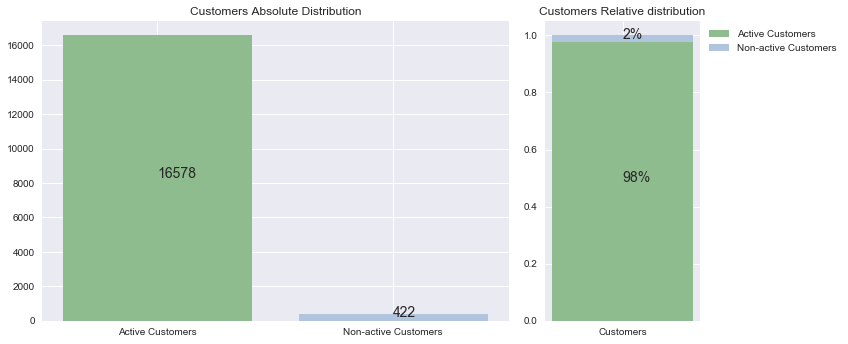

In [66]:
num_active = transactions_summary.shape[0]
num_non_active = customers.shape[0] - transactions_summary.shape[0]
num_active_frac = num_active/customers.shape[0] 
num_non_active_frac = num_non_active/customers.shape[0]  

fig = plt.figure(figsize=(12, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1])

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['Active Customers', 'Non-active Customers'], [num_active,num_non_active], color=['darkseagreen','lightsteelblue']) 
ax0 = plt.title('Customers Absolute Distribution') 
ax0 = plt.text(['Active Customers'], num_active/2, num_active) 
ax0 = plt.text(['Non-active Customers'], num_non_active/2, num_non_active) 

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Customers'], [num_active_frac], label='Active Customers', color=['darkseagreen'])
ax1 = plt.bar(['Customers'], [num_non_active_frac], bottom=num_active_frac, label='Non-active Customers', color=['lightsteelblue'])
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Customers Relative distribution')
#ax1 = plt.ylabel('Rate')
ax1 = plt.text(['Customers'],num_active_frac/2, '{}%'.format(round(num_active_frac*100)))
ax1 = plt.text(['Customers'],(num_non_active_frac/2)+num_active_frac, '{}%'.format(round(num_non_active_frac*100)))

plt.tight_layout()
plt.show()

Just only 2% of customers who receive offers do not make transactions during the campaign period. 

**Gender, age, income and money spent**

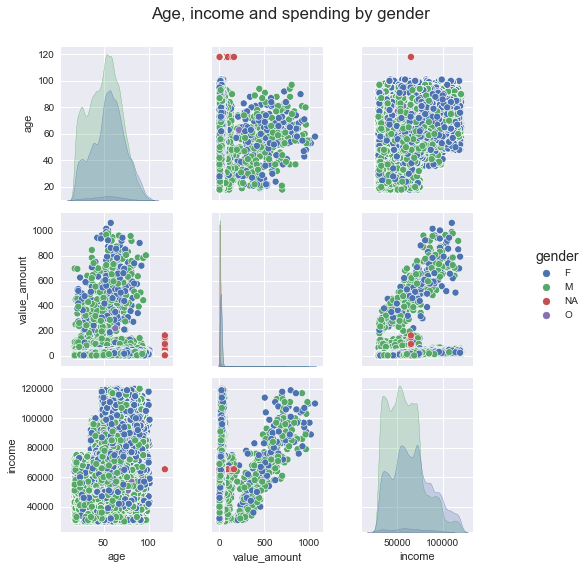

In [107]:
plot1 = sns.pairplot(transactions[['gender', 'age', 'value_amount', 'income']], hue='gender')
plot1.fig.suptitle("Age, income and spending by gender", y=1.05)
plt.show()

income and monetary value of spending are possitively correlated. 

**Counts of offers**

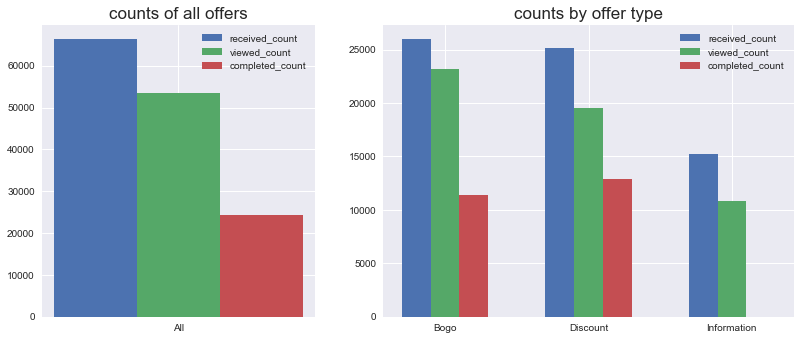

In [69]:
fig = plt.figure(figsize=(12, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2,3])

received_count = customers[['BOGO_received_count','DISC_received_count','INFO_received_count']].sum()       
viewed_count = customers[['BOGO_viewed_count','DISC_viewed_count','INFO_viewed_count']].sum()
completed_count = customers[['BOGO_completed_count','DISC_completed_count','INFO_completed_count']].sum()
all_count = customers[['ALL_received_count','ALL_viewed_count','ALL_completed_count']].sum()

width = 0.2

ax0 = plt.subplot(gs[0])
ax0.bar(0 -  width, all_count[0], width,label='received_count')
ax0.bar(0 , all_count[1], width,label='viewed_count')
ax0.bar(0+  width, all_count[2], width,label='completed_count')
ax0.set_xticks([0])
ax0.set_xticklabels(['All'])
ax0.legend()
ax0.set_title('counts of all offers',size=17)

ax1 = plt.subplot(gs[1])
labels = ['Bogo','Discount','Information']
ind = np.arange(len(labels))

#fig = plt.figure()
#ax1 = fig.add_axes([0,0,1,1])
ax1.bar(ind -  width, received_count, width,label='received_count')
ax1.bar(ind , viewed_count, width,label='viewed_count')
ax1.bar(ind +  width, completed_count, width,label='completed_count')
ax1.set_xticks(ind)
ax1.set_xticklabels(labels)
ax1.set_title('counts by offer type',size=17)
ax1.legend()


plt.show()

**Observation from the total counts chart:**

The number of customers viewing offers is more than two third of the number of customers receiving offers. 

However, the number of customers completing offers is just less than half of the number of customers viewing offers. This can be explained by several reasons such as offers are not appealing or the levels of offer are difficult. Let's examine the counts by offer type chart to see in which offer type has this problem. 

**Observation from the counts by offer type chart:**

The ratio between the number of customers viewing offers and the number of customers receiving offers is aligned with what is observed in the total counts chart. 

The ratio between the number of customers completing offers and the number of customers viewing offers for BOGO is lower than that of Discount. There is no customers completing Information. Thus, the reason for the previous suspection on why the number of customers completing offers is less than half of the number of customers viewing offers can be narrowed down BOGO and Information. Regarding Information, there is no reward for Information type. Regarding BOGO, from portfolio dataset, it has lower difficult level, higher reward level but shorter offer time compared to Discount. 

In [70]:
portfolio

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
5  2298d6c36e964ae4a3e7e9706d1fb8c2       discount       3  
6  fafdcd668e3743c1bb461111dcafc2a4       discount       2  
7  5a8bc65990b245e5a138643cd4eb9837  informational       0  
8  f19421c1d4aa40978ebb69ca19b0e20d           bogo       5  
9  2906b810c7d4411798c6938adc9daaa5       discount       2

**Conversion**

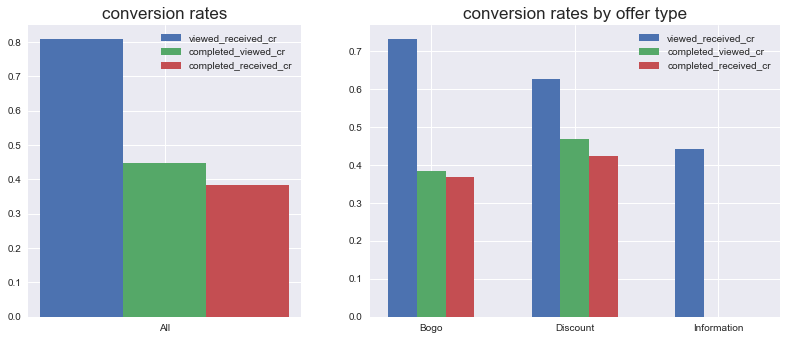

In [71]:
fig = plt.figure(figsize=(12, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2,3])

viewed_received_cr = customers[['BOGO_viewed_received_cr','DISC_viewed_received_cr','INFO_viewed_received_cr']].mean()        
completed_viewed_cr = customers[['BOGO_completed_viewed_cr','DISC_completed_viewed_cr','INFO_completed_viewed_cr']].mean()
completed_received_cr = customers[['BOGO_completed_received_cr','DISC_completed_received_cr','INFO_completed_received_cr']].mean()
all_cr = customers[['ALL_viewed_received_cr','ALL_completed_viewed_cr','ALL_completed_received_cr']].mean()

width = 0.2
ind = np.arange(len(labels))

ax0 = plt.subplot(gs[0])
ax0.bar(0 -  width, all_cr[0], width,label='viewed_received_cr')
ax0.bar(0 , all_cr[1], width,label='completed_viewed_cr')
ax0.bar(0+  width, all_cr[2], width,label='completed_received_cr')
ax0.set_xticks([0])
ax0.set_xticklabels(['All'])
ax0.legend()
ax0.set_title('conversion rates',size=17)

ax1 = plt.subplot(gs[1])
labels = ['Bogo','Discount','Information']

#fig = plt.figure()
#ax1 = fig.add_axes([0,0,1,1])
ax1.bar(ind -  width, viewed_received_cr, width,label='viewed_received_cr')
ax1.bar(ind , completed_viewed_cr, width,label='completed_viewed_cr')
ax1.bar(ind +  width, completed_received_cr, width,label='completed_received_cr')
ax1.set_xticks(ind)
ax1.set_xticklabels(labels)
ax1.set_title('conversion rates by offer type',size=17)
ax1.legend()


plt.show()

BOGO has the highest viewed_vs_received conversion rate among three types, but lower completed_vs_viewed and completed_vs_received conversion rates than Discount. High viewed_vs_received conversion rate indicates that customers seem to be more interested in BOGO idea than Discount and Information. However, low completed_vs_viewed conversion rate indicates that the content of BOGO offer is not that appealing to get customers into buying as after viewing the offer, many customers decided not to use the offer. 

**Check BOGO conversion rates by different level of difficulty, duration, and reward.**

In [72]:
portfolio[portfolio['offer_type'] == 'bogo']

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
3          [web, email, mobile]           5         7   
8  [web, email, mobile, social]           5         5   

                                 id offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd       bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0       bogo      10  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9       bogo       5  
8  f19421c1d4aa40978ebb69ca19b0e20d       bogo       5

There are 4 types of BOGO offer with different difficulty, duration, and reward.

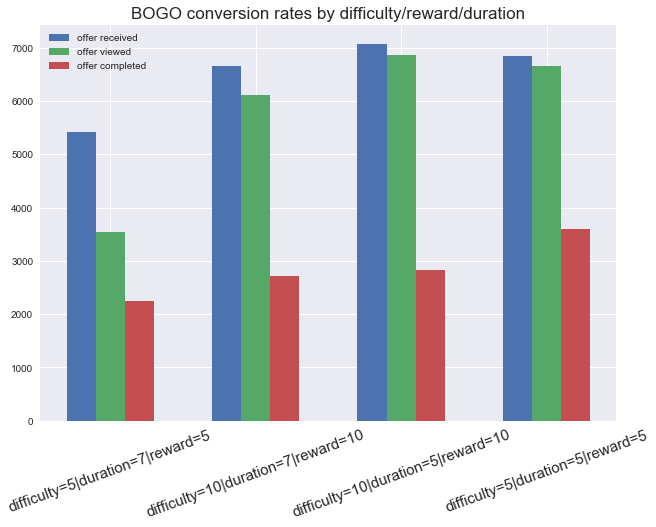

In [73]:
bogo_by_content = grouped_offers[grouped_offers.bogo == 1].groupby(['offer_id'])[['offer received', 'offer viewed','offer completed']].sum()
bogo_by_content.sort_values(by=['offer completed'],inplace=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['difficulty=5|duration=7|reward=5','difficulty=10|duration=7|reward=10', 'difficulty=10|duration=5|reward=10', 'difficulty=5|duration=5|reward=5']
ind = np.arange(len(labels))
width = 0.2

ax.bar(ind -  width, bogo_by_content['offer received'], width,label='offer received')
ax.bar(ind , bogo_by_content['offer viewed'], width,label='offer viewed')
ax.bar(ind +  width, bogo_by_content['offer completed'], width,label='offer completed')
ax.set_xticks(ind)
ax.set_xticklabels(labels,size=15,rotation =20)
ax.set_title('BOGO conversion rates by difficulty/reward/duration',size=17)
ax.legend()

plt.show()

So it is confirmed that the reason behind low BOGO conversion rate (even though with a very high view rate) is because of the difficulty/reward levels and duration. The least difficult and longest duration BOGO offer yields the highest completed_vs_viewed/completed_vs_received conversion rates. The most difficult and shortest duration BOGO offer yields the least  completed_vs_viewed/completed_vs_received conversion rates.

**Check DISCOUNT conversion rates by different level of difficulty, duration, and reward.**

In [74]:
portfolio[portfolio['offer_type'] == 'discount']

channels  difficulty  duration  \
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
9          [web, email, mobile]          10         7   

                                 id offer_type  reward  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7   discount       5  
5  2298d6c36e964ae4a3e7e9706d1fb8c2   discount       3  
6  fafdcd668e3743c1bb461111dcafc2a4   discount       2  
9  2906b810c7d4411798c6938adc9daaa5   discount       2

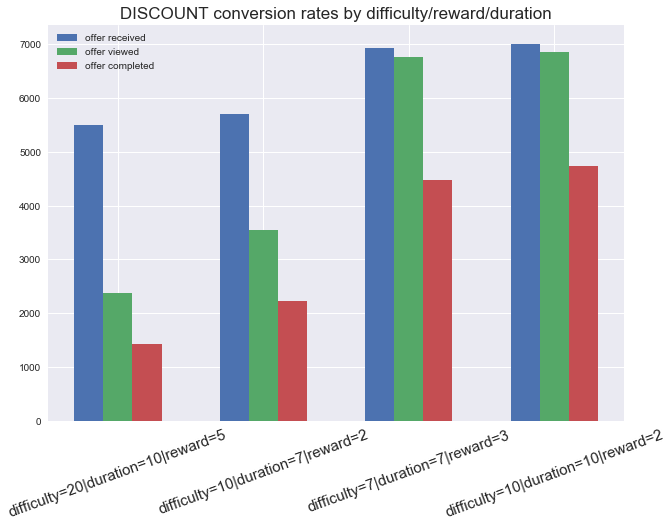

In [75]:
discount_by_content = grouped_offers[grouped_offers.discount == 1].groupby(['offer_id'])[['offer received', 'offer viewed','offer completed']].sum()
discount_by_content.sort_values(by=['offer completed'],inplace=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['difficulty=20|duration=10|reward=5','difficulty=10|duration=7|reward=2', 'difficulty=7|duration=7|reward=3', 'difficulty=10|duration=10|reward=2']
ind = np.arange(len(labels))
width = 0.2

ax.bar(ind -  width, discount_by_content['offer received'], width,label='offer received')
ax.bar(ind , discount_by_content['offer viewed'], width,label='offer viewed')
ax.bar(ind +  width, discount_by_content['offer completed'], width,label='offer completed')
ax.set_xticks(ind)
ax.set_xticklabels(labels,size=15,rotation=20)
ax.set_title('DISCOUNT conversion rates by difficulty/reward/duration',size=17)
ax.legend()

plt.show()

It does not seem there is much difference in conversion rates among different types of DISCOUNT offer. 

**Offer type effectiveness conclusion**

Overall, Discount drives higher conversion rates than BOGO.

Customers seems to be more interested in BOGO idea than DISCOUNT as they view more BOGO than DISCOUNT. However, the difficulty, reward, and duration level of BOGO drive customers away from completing offers. It is observed that the BOGO offer with low difficulty level and long duration has even higher completed_vs_viewed conversion rate than any type of DISCOUNT offer. Marketing team can design an easier BOGO offer for future campaigns. 

# Feature preprocessing

In [64]:
train_features=customers[['age', 'income', 'frequency', 'recency', 'monetary_value',
       'BOGO_viewed_received_cr', 'BOGO_completed_viewed_cr', 'DISC_viewed_received_cr',
       'DISC_completed_viewed_cr',
       'INFO_viewed_received_cr',  
       'ALL_completed_viewed_cr',
       'reward_average', 'difficulty_average', 'email_count', 'mobile_count',
       'social_count', 'web_count', 'BOGO_count', 'DISC_count', 'INFO_count','ALL_received_count', 
        'ALL_viewed_count','ALL_completed_count',
       'ALL_received_average', 'ALL_viewed_average', 'ALL_completed_average',
       'gender_F', 'gender_M', 'gender_O', 'joined_since_2013',
       'joined_since_2014', 'joined_since_2015', 'joined_since_2016',
       'joined_since_2017', 'joined_since_2018']]

Since all the features are either in numeric or transformed into numeric, PCA will be performed on them to reduce dimensionality. 

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [66]:
scaler = StandardScaler().fit(train_features)
scaled_df = scaler.transform(train_features)

In [67]:
pca_data = PCA()
fit_pca = pca_data.fit(scaled_df)

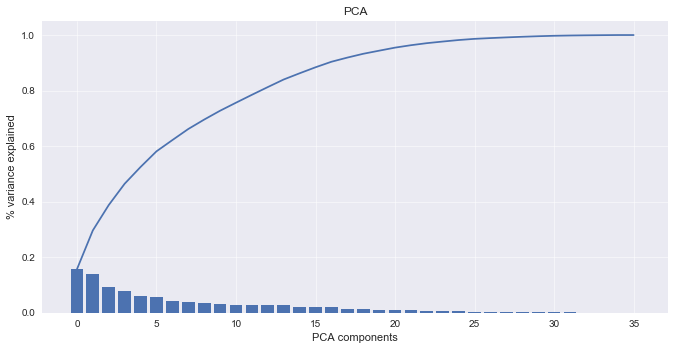

In [80]:
components=len(pca_data.explained_variance_ratio_)
plt.figure(figsize=(10,5))
plt.bar(np.arange(components),pca_data.explained_variance_ratio_)
plt.plot(np.cumsum(pca_data.explained_variance_ratio_))
plt.grid(b=True,which='major',linewidth=0.5)
plt.ylabel('% variance explained')
plt.xlabel('PCA components')
plt.title('PCA')
plt.show()

In [68]:
components= 12
pca_data = PCA(components).fit_transform(scaled_df)
pca_data = pd.DataFrame(pca_data)

# Models

## KMeans

### Find the number of clusters

I will use the following methods to find the number of KMeans clusters:
- kelbow_visualizer from yellowbrick - elbow
- kelbow_visualizer from yellowbrick - silhouette score
- silhouette_score, calinski_harabasz_score, davies_bouldin_score from sklearn

**kelbow_visualizer from yellowbrick**

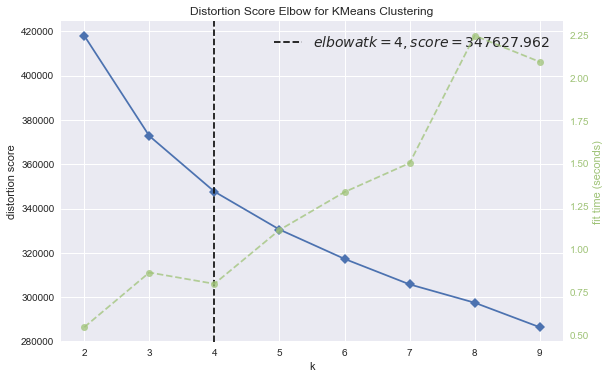

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001B0C9FD4EB8>,
                 k=None, model=None)

In [82]:
kelbow_visualizer(KMeans(), pca_data, k=(2,10))

It seems that the data is not well clustered as we see a smooth curve (no clear visual of elbow) in the above Elbow method. The optimal K is not so clear here.

optimal K might be 4

**silhouette_score, calinski_harabasz_score, davies_bouldin_score from sklearn**

- **Silhouette Coefficient** The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. The best value is 1 and the worst value is -1.

- **Calinski Harabasz** The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.

- **Davies-Bouldin** The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score. The minimum score is zero, with lower values indicating better clustering.

In [142]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10, 
    "max_iter": 300,
    "random_state": 42,}

silhouette_scores = []
calinski_harabasz_scores= []
davies_bouldin_scores = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pca_data)
    
    silhouette = silhouette_score(customers, kmeans.labels_)
    silhouette_scores.append(silhouette)
    
    calinski_harabasz = calinski_harabasz_score(customers, kmeans.labels_)
    calinski_harabasz_scores.append(calinski_harabasz)
    
    davies_bouldin = davies_bouldin_score(customers, kmeans.labels_)
    davies_bouldin_scores.append(davies_bouldin)

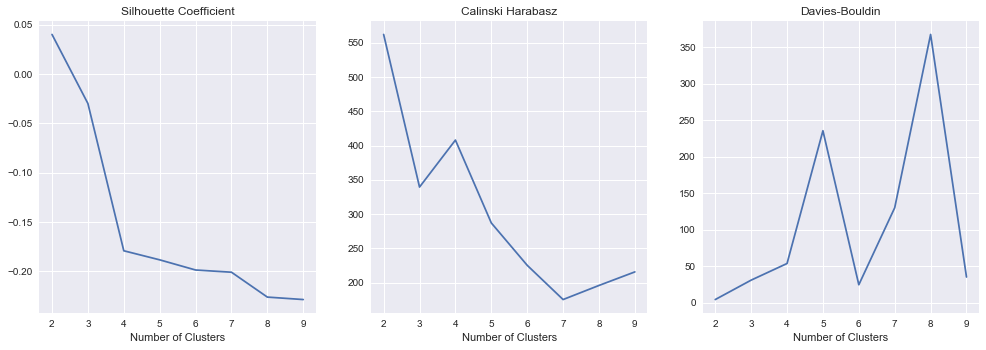

In [144]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.plot(range(2,10),silhouette_scores)
plt.xticks(range(2,10))
plt.xlabel("Number of Clusters")
plt.title('Silhouette Coefficient')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(2,10),calinski_harabasz_scores)
plt.xticks(range(2,10))
plt.xlabel("Number of Clusters")
plt.title('Calinski Harabasz')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(2,10),davies_bouldin_scores)
plt.xticks(range(2,10))
plt.xlabel("Number of Clusters")
plt.title('Davies-Bouldin')
plt.grid(True)

plt.show()

4 seems to be the optimal K. Because it has high Silhouette Coefficient, high Calinski Harabasz and low Davies-Bouldin.

### Fit KMean model

From above result, I will choose 4 as the number of clusters for KMeans.

In [69]:
KMeans_model = KMeans(n_clusters=4, random_state=42).fit(pca_data)
kmeans_clusters = KMeans_model.predict(pca_data)

**Visualize Silhouette scores for each cluster**

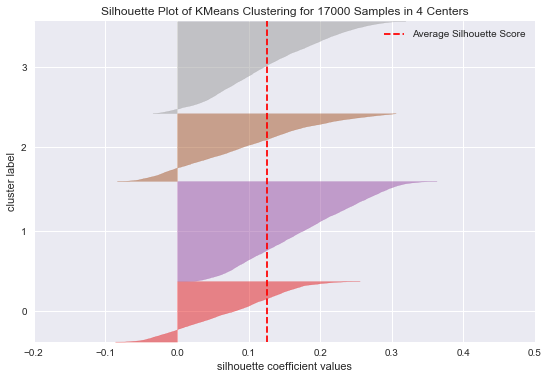

In [87]:
visualizer = SilhouetteVisualizer(KMeans_model)
visualizer.fit(pca_data)    # Fit the data to the visualizer
visualizer.poof()  

The width of each silhouette is proportional to the number of samples assigned to the cluster so we can see that cluster 1 and 3 are assigned with more data points (customers) than cluster 0 and 2. The Silhouette score of 4 clusters are quite cohesive as all have values over average Silhouette score. 

In [75]:
pd.DataFrame({'Cluster': list(Counter(kmeans_clusters).keys()),'Data points':list(Counter(kmeans_clusters).values())})

Cluster  Data points
0        4         2040
1        0         2833
2        3         3050
3        2         4305
4        1         4772

**Visualize how distinct these clusters on PCA components**

Look at clusters' composition on PCA components

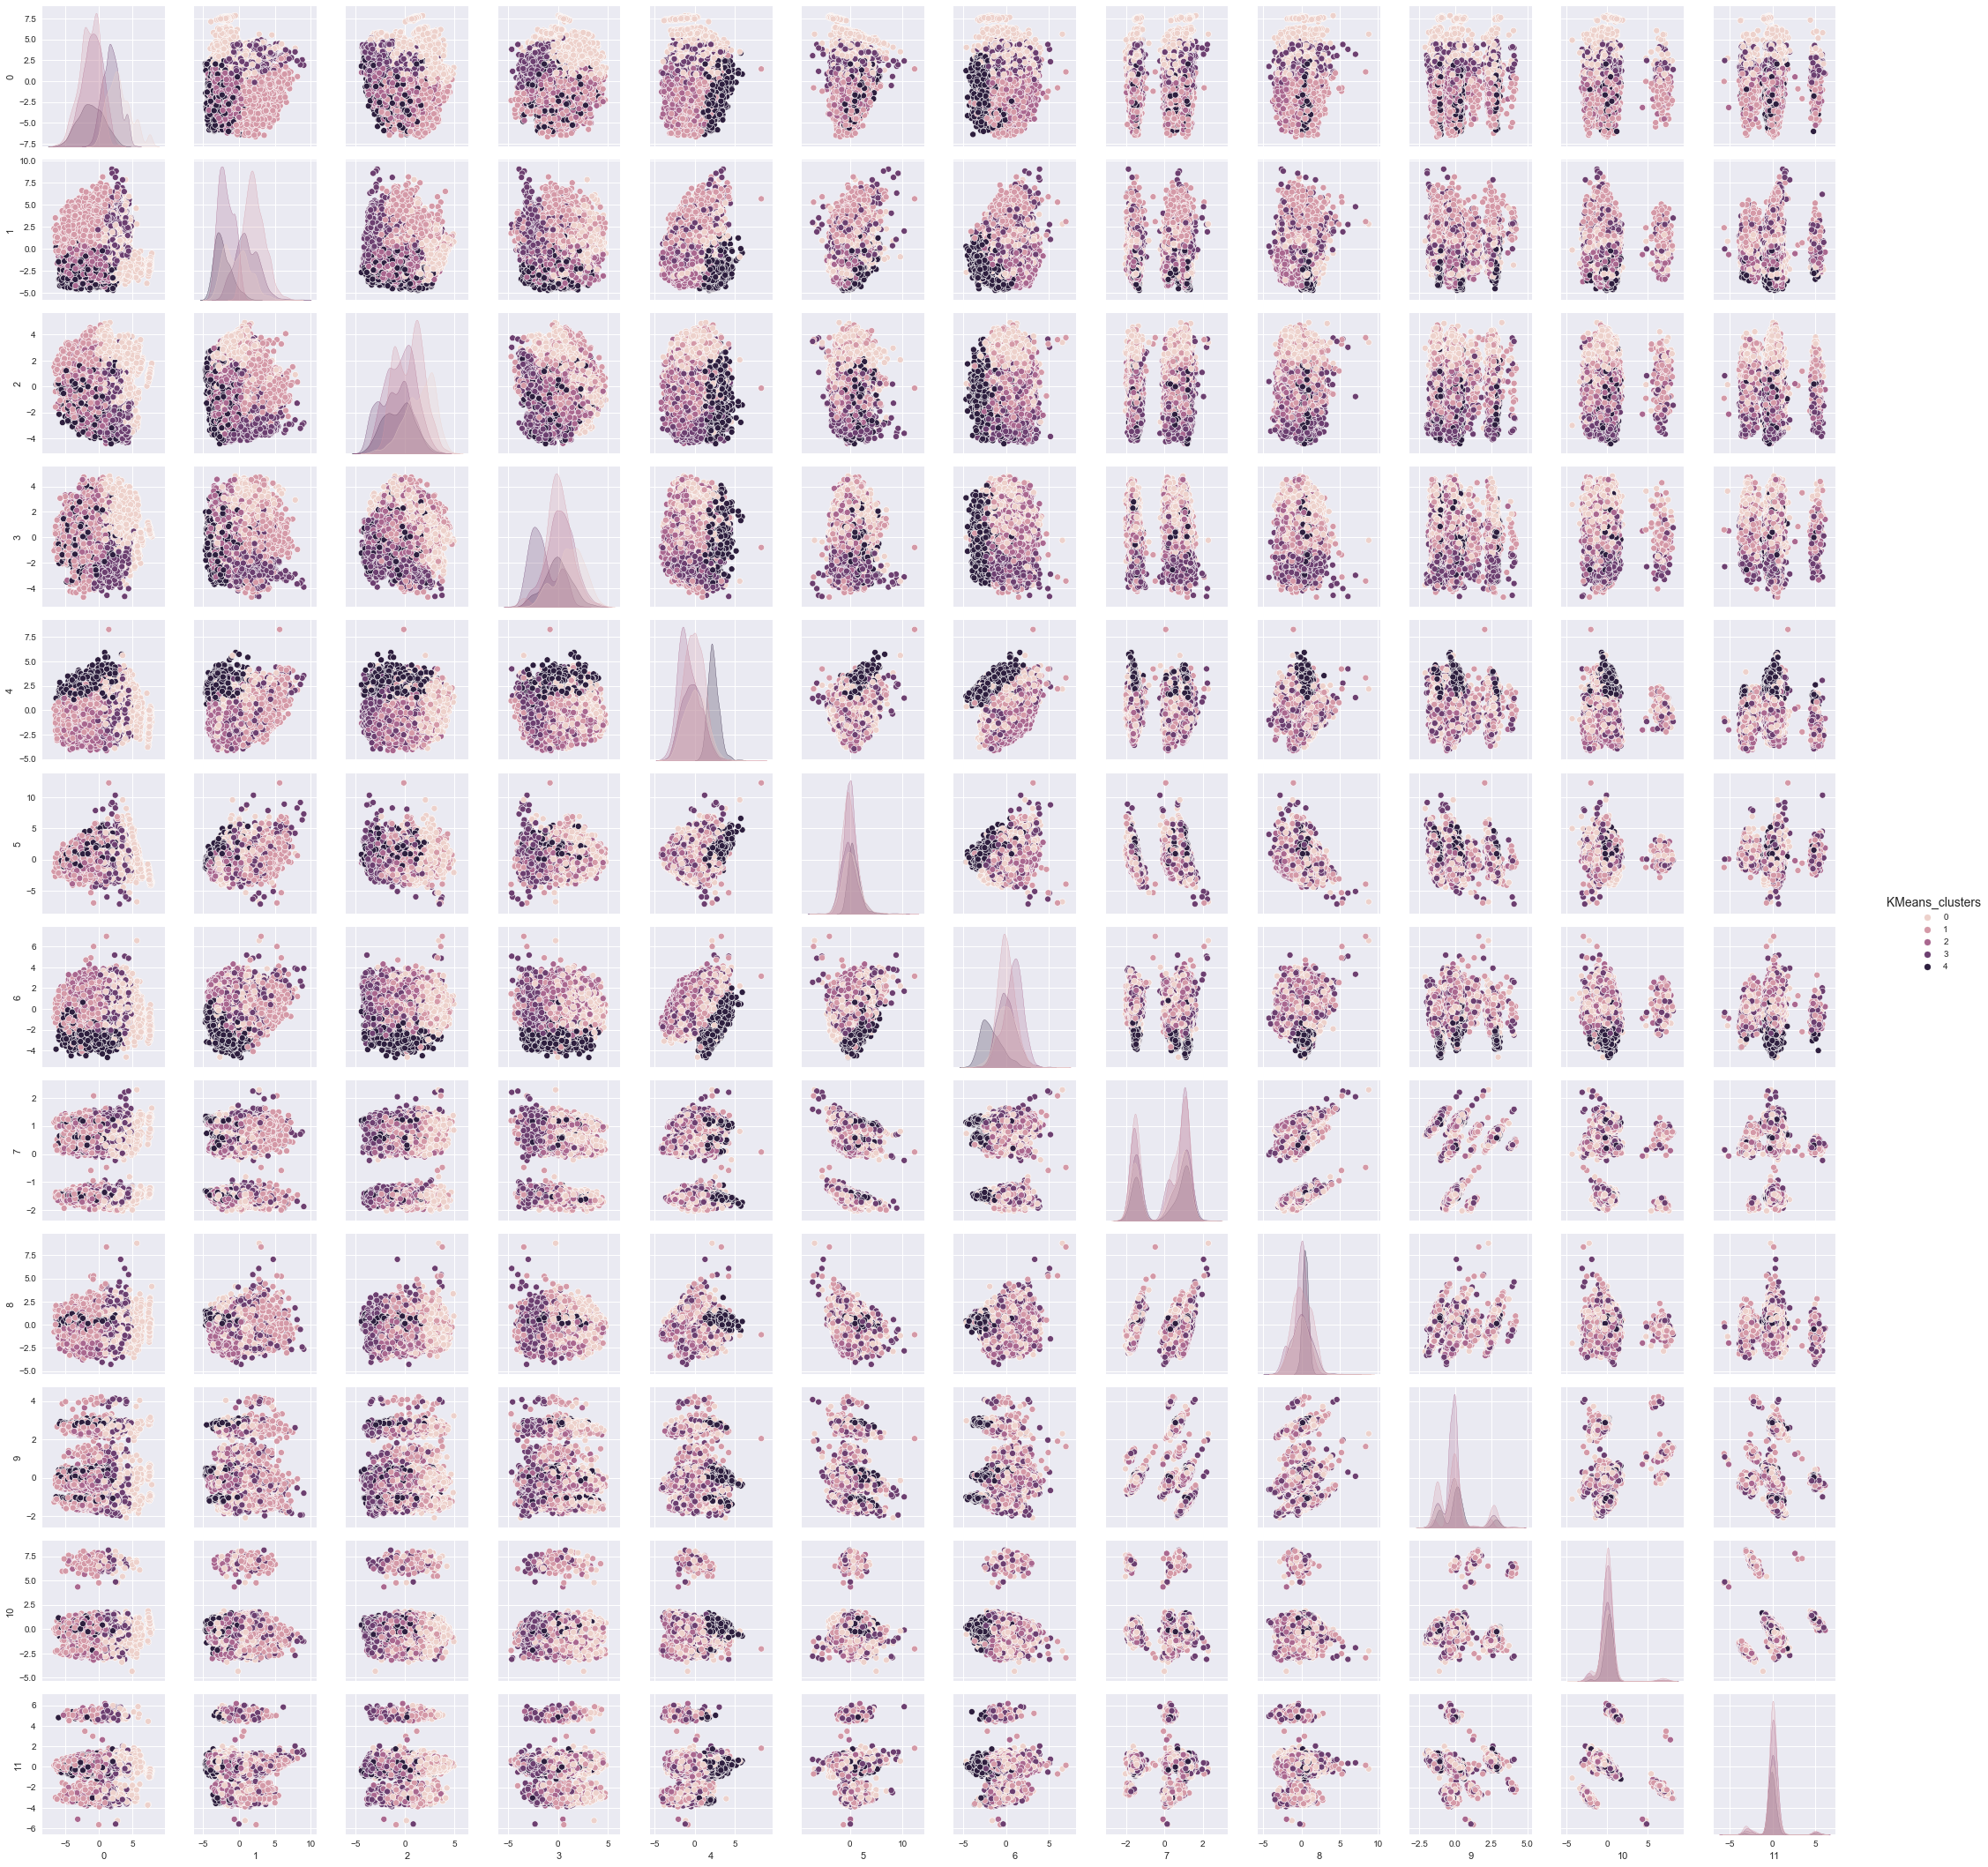

In [150]:
KMeans_df_pca = pca_data.copy()
KMeans_df_pca['KMeans_clusters'] = kmeans_clusters
sns.pairplot(KMeans_df_pca, hue='KMeans_clusters',palette='viridis')

## DBSCAN

### Find the parameters
Find the parameters for DBSCAN which produce the highest Silhouette score

In [ ]:
from itertools import product

In [580]:
eps = np.arange(2.25,4,0.25) 
min_samples = np.arange(65,75)
DBSCAN_params = list(product(eps,min_samples))

num_clusters = []
silhouette_scores = []

for param in DBSCAN_params:    
    DBSCAN_model = DBSCAN(eps=param[0], min_samples=param[1]).fit(pca_data)
    num_clusters.append(len(np.unique(DBSCAN_model.labels_)))
    silhouette_scores.append(silhouette_score(pca_data, DBSCAN_model.labels_))

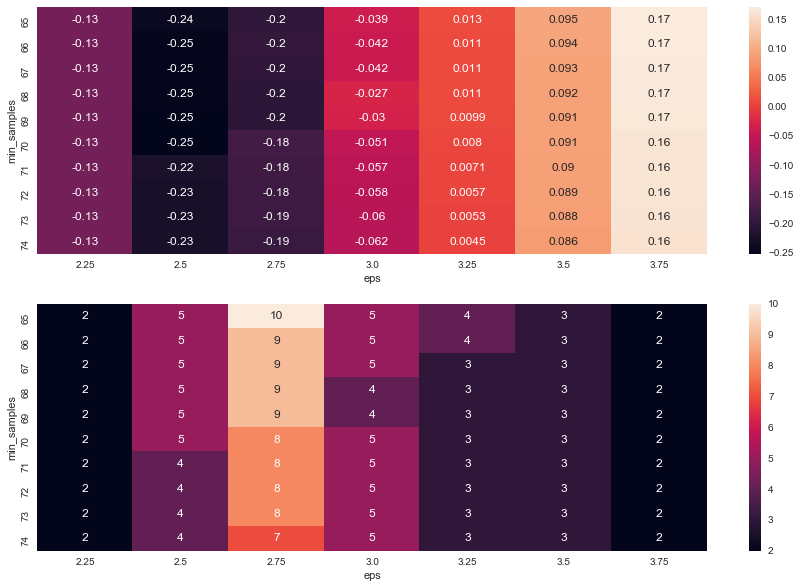

In [582]:
DBSCAN_params_df = pd.DataFrame.from_records(DBSCAN_params, columns = ['eps','min_samples'])
DBSCAN_params_df['silhouette_scores'] = silhouette_scores
DBSCAN_params_df['num_clusters'] = num_clusters

params_sil_pivot = pd.pivot_table(DBSCAN_params_df, values = 'silhouette_scores', index='min_samples', columns='eps')
params_num_pivot = pd.pivot_table(DBSCAN_params_df, values = 'num_clusters', index='min_samples', columns='eps')

plt.figure(figsize=(15,10))
plt.subplot(211)
sns.heatmap(params_sil_pivot, annot= True)

plt.subplot(212)
sns.heatmap(params_num_pivot, annot= True)


plt.show()


The highest silhouette score = 0.17 with parameters: eps=3.75, min_samples=65. But with these parameters the model is able to output only 2 clusters.

### Fit model


In [106]:
DBSCAN_model =  DBSCAN(eps=3.75, min_samples=65)
dbscan_clusters = DBSCAN_model.fit_predict(pca_data)

In [107]:
pd.DataFrame({'Cluster': list(Counter(dbscan_clusters).keys()),'Data points':list(Counter(dbscan_clusters).values())})

Cluster  Data points
0       -1          902
1        0        16098

We see that cluster -1 is actually outliers. The parameters that can create highest silhouette score does not work well.

Let's test with parameters that can create 4 clusters.

In [109]:
DBSCAN_model =  DBSCAN(eps=3.25, min_samples=65)
dbscan_clusters = DBSCAN_model.fit_predict(pca_data)

In [110]:
pd.DataFrame({'Cluster': list(Counter(dbscan_clusters).keys()),'Data points':list(Counter(dbscan_clusters).values())})

Cluster  Data points
0       -1         4784
1        2           67
2        0        12006
3        1          143

The model classifies 4784 points as outliers. The sizes of clusters vary significantly. DBSCAN seems to not be able to create reasonable clusters as its disadvantage is to recognize clusters of various densities 

# Model Evaluation

KMeans outperforms DBSCAN so I choose the results from KMeans for evaluation.

**KMEANS**

In [70]:
kmeans_df = train_features.copy()
kmeans_df = kmeans_df.reset_index()
kmeans_df['cluster'] = kmeans_clusters

In [90]:
kmeans_df_melt = kmeans_df.melt(id_vars=['person', 'cluster'])
kmeans_df_melt = kmeans_df_melt[kmeans_df_melt['cluster'] != '-1'].groupby(['cluster', 'variable']).mean().reset_index()
kmeans_df_melt.head()

cluster                 variable     value
0        0    ALL_completed_average  0.931251
1        0      ALL_completed_count  1.909543
2        0  ALL_completed_viewed_cr  0.807036
3        0     ALL_received_average  1.352373
4        0       ALL_received_count  2.829655

**Plot the clusters' average statistics for each feature**

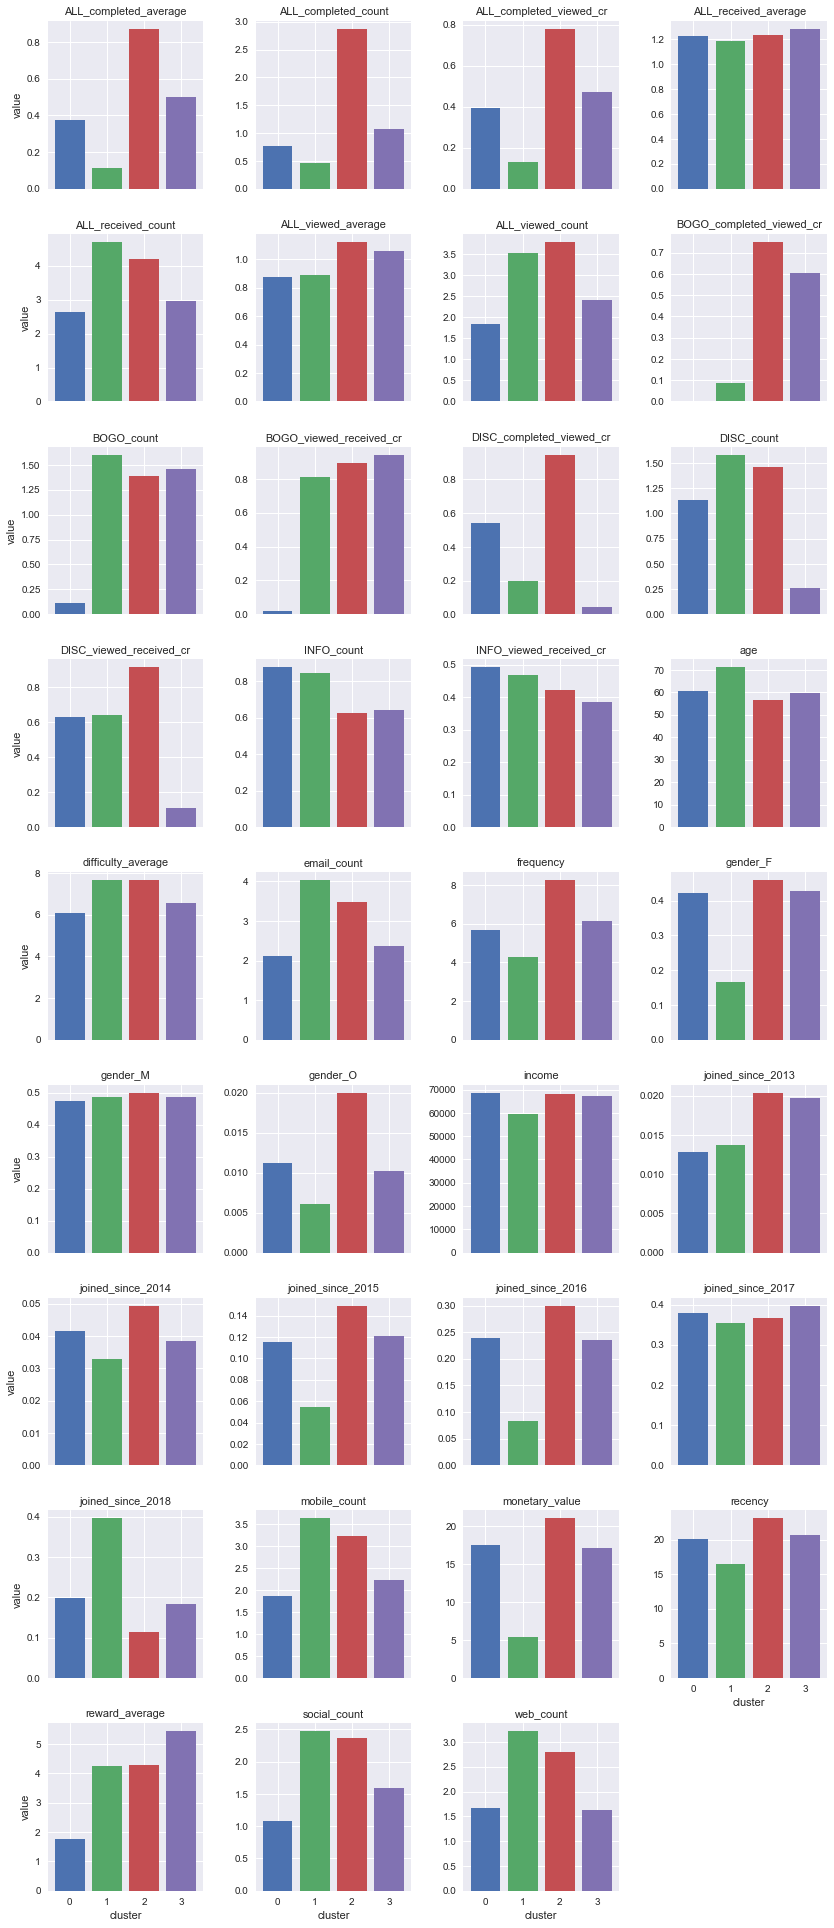

In [150]:
kmeans_facetgrid = sns.FacetGrid(kmeans_df, col='variable', hue='cluster', col_wrap=4, sharey=False)
kmeans_facetgrid= kmeans_facetgrid.map(plt.bar, 'cluster', 'value').set_titles("{col_name}")

***Radar chart***

In [71]:
kmeans_df_radar =kmeans_df[['age', 'income', 'frequency', 'recency', 'monetary_value',
           'BOGO_completed_viewed_cr','DISC_completed_viewed_cr','INFO_viewed_received_cr',
          'BOGO_count', 'DISC_count', 'INFO_count','gender_F', 'gender_M','cluster']]
kmeans_df_radar = kmeans_df_radar.groupby('cluster').mean()

In [88]:
class RadarChart():
    def __init__(self,rect,features,features_ranges,num_yticks=6):
        
        # split circle into even angles for each feature and save the angles
        angles = np.linspace(0,2*np.pi,len(features),endpoint=False).tolist()
        
        # create axes for features (each feature has 1 axes)
        list_of_axes = [fig.add_axes(rect, polar=True, label=f"axes{x}") for x in range(len(features))]
        
        # Draw axis lines for each angle and label in the first axes
        list_of_axes[0].set_thetagrids(np.degrees(angles),features)
        
        # Adjust the alignment of each label in the first axes
        for label,angle in zip(list_of_axes[0].get_xticklabels(),angles):
            if np.radians(-1) < angle < np.radians(181):
                label.set_rotation(angle - np.radians(90))
            else:
                label.set_rotation(angle - np.radians(270))

        # Make other axes invisible
        for axes in list_of_axes[1:]:
            axes.grid("off")
            axes.xaxis.set_visible(False)
            axes.patch.set_visible(False)
            
        for index, axes in enumerate(list_of_axes):
            grid = np.linspace(*features_ranges[index],num=num_yticks)
            label = [""] + [f"{i:.0f}" for i in grid[1:-1]]
            axes.set_rgrids(grid,labels=label,angle=np.degrees(angles)[index])
            axes.set_ylim(*features_ranges[index])
        
        angles += angles[:1]
        self.angles = angles
        self.features_ranges = features_ranges
        self.axes = list_of_axes[0]
        
    def scale_data(self,df,*args,**kw):
        (i1, i2) = self.features_ranges[0]
        data = df[0]
        scaled_data = [(data - j1) / (j2 - j1) * (i2 - i1) + i1 for data, (j1, j2) in zip(df, self.features_ranges)]
        return scaled_data

            
    def plot(self,scaled_data,*args,**kw):
        self.axes.plot(self.angles,np.r_[scaled_data,scaled_data[0]],*args,**kw)
    def fill(self,scaled_data,*args,**kw):
        self.axes.fill(self.angles,np.r_[scaled_data,scaled_data[0]],*args,**kw)
    def title(self,title,*args,**kw):
        self.axes.text(0.4,-0.15,title,transform=self.axes.transAxes,*args,**kw)


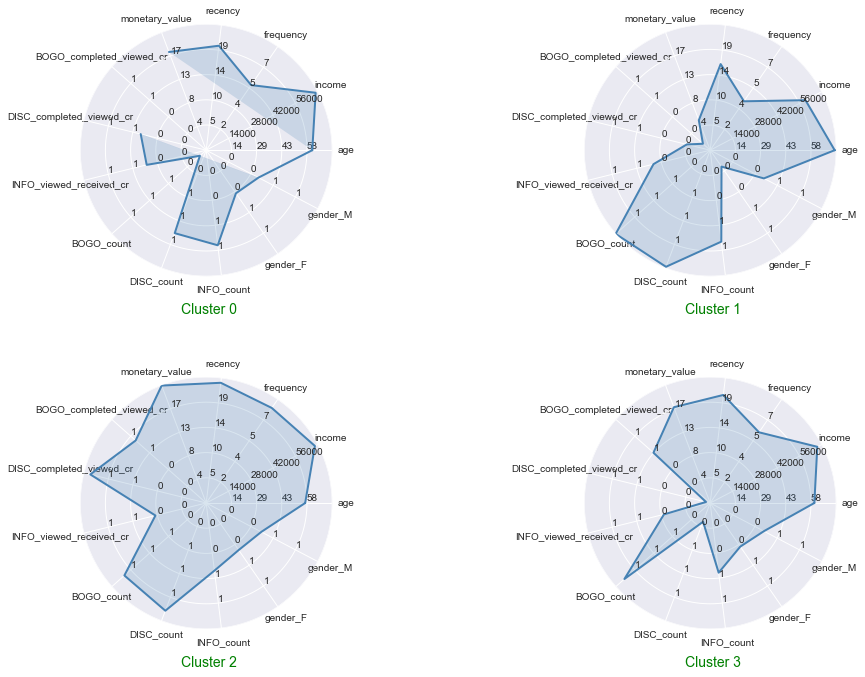

In [89]:
features = ['age', 'income', 'frequency', 'recency', 'monetary_value',
           'BOGO_completed_viewed_cr','DISC_completed_viewed_cr','INFO_viewed_received_cr',
          'BOGO_count', 'DISC_count', 'INFO_count',
            'gender_F', 'gender_M']

features_ranges = [
                   [0.01,72], [0.01,70000], [0.01, 9], [0.01, 24], [0.01, 21.1],
                   [0.01,1],[0.01,1],[0.01,1],
                   [0.01,1.6],[0.01,1.6],[0.01,1.15], 
                   [0.01,1], [0.01,1]
                  ]

index_ranges  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

num_clusters = 4
num_columns = 2
num_rows = num_clusters//num_columns
width, height = (1/num_columns), (1/num_rows)

fig = plt.figure(figsize =(10,7))
for index in range(num_clusters):
    x = index%2
    y = num_rows - index//2
    left = x*(width + 0.2)
    bottom = y*(height + 0.2)   
    rect = [left, bottom, width, height]
    data = np.array(kmeans_df_radar.loc[index_ranges[index], features])    
    radar = RadarChart(rect, features, features_ranges)
    scaled_data = radar.scale_data(data)
    radar.plot(scaled_data, color = 'steelblue', linewidth=2.0)
    radar.fill(scaled_data, alpha = 0.2, color = 'steelblue')
    radar.title(title = f'Cluster {index_ranges[index]}',color='green')
    index += 1 

**Cluster 0** regular customers who make regular transactions without being incentivised by offers.

**Cluster 1** male, receive all three types of offer but do not response to any.

**Cluster 2** convert very well with Discount offer type. 

**Cluster 3** receive only BOGO and INFO offers, and convert quite well with BOGO offer type.